# Step 1-2: Feature Selection

### Search for which lagged variables to include for training
- population, gdp, energy proportions, energy mix

* proportion for fossil fuels

* proportion for coal

* proportion for the renewabales

### HHF - Herfindahl-Hirshmann Index: sum over the squared proportions

## Summary

summary 

In [169]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings

warnings.filterwarnings("ignore")

In [170]:
# Config
TARGET_VARIABLES = 'co2'
CANDIDATE_FEATURES = ['gdp', 'primary_energy_consumption']
G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]
SELECTED_COUNTRIES = ['United States', 'China', 'India']
MAX_LAGS = 4
TEST_SIZE = 9

# Important features to include
IMPORTANT_FEATURES = [
    'population',
    'gdp',
    'primary_energy_consumption',
    #'Proportions', # These are below
    #'Energy_mix' 
]

# HHI =  a^2 + b^2 + c^2 -> lags -> pct_change norm
"""
# ENERGY_MIX columns in this dataframe

Total Energy = Fossil + Low_carbon
Fossil = coal + oil + gas
Low_carbon = nuclear + Renewables
Renwables = biofuel + solar + hydro + wind + other_renewables
"""

# Categories for the variables
# The total sum for each category should be excluded

# Using this hhi would be better since including all detailed columns would be granular?
TOTAL_PROPORTIONS = [
    'fossil_share_energy',
    'low_carbon_share_energy'
]

FOSSIL_PROPORTIONS = [
    #'fossil_share_energy',
    'coal_share_energy',
    'oil_share_energy',
    'gas_share_energy'
]

LOW_CARBON_PROPORTIONS = [
    'nuclear_share_energy',
    #'renewables_share_energy', # This renewables share is the total share of primary energy from all (including solar, ...)
    'biofuel_share_energy',
    'solar_share_energy',
    'wind_share_energy',
    'hydro_share_energy',
    'other_renewables_share_energy'
]

DETAILED_PROPORTIONS = FOSSIL_PROPORTIONS + LOW_CARBON_PROPORTIONS

In [171]:
def load_data(save_dir='data'):
    data_files = {
        'all_data_df': os.path.join(save_dir, 'all_data_df.csv'),
        'g20_lag_df': os.path.join(save_dir, 'g20_lag_df.csv'),
        'lag_three_sel_1969_df': os.path.join(save_dir, 'lag_three_sel_1969_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [172]:
data = load_data()
all_data_df = data['all_data_df']
g20_lag_df = data['g20_lag_df']
g20_lag_1969_df = g20_lag_df[g20_lag_df['year'] >= 1969].copy()
g20_lag_1969_df = g20_lag_1969_df[g20_lag_1969_df['year'] < 2023]
lag_three_sel_1969_df = data['lag_three_sel_1969_df']

Loaded all_data_df: (55529, 200)
Loaded g20_lag_df: (3744, 992)
Loaded lag_three_sel_1969_df: (162, 992)


In [173]:
# train_test_split
def tts_by_year(df, test_size=9):
    train_data = {}
    test_data = {}

    for country in df['country'].unique():
        country_data = df[df['country'] == country].sort_values('year')

        split_idx = len(country_data) - test_size
        train_data[country] = country_data.iloc[:split_idx]
        test_data[country] = country_data.iloc[split_idx:]

    train_df = pd.concat(train_data.values(), ignore_index=True)
    test_df = pd.concat(test_data.values(), ignore_index=True)

    return train_df, test_df

In [174]:
train_3_df, test_3_df = tts_by_year(lag_three_sel_1969_df, TEST_SIZE)
train_g20_df, test_g20_df = tts_by_year(g20_lag_1969_df, TEST_SIZE)

print(f"3 countries train shape: {train_3_df.shape}")
print(f"3 countries train years: {train_3_df['year'].min()} - {train_3_df['year'].max()}")
print(f"3 countriees test years: {test_3_df['year'].min()} - {test_3_df['year'].max()}")

3 countries train shape: (135, 992)
3 countries train years: 1969 - 2013
3 countriees test years: 2014 - 2022


In [175]:
for col in DETAILED_PROPORTIONS:
    if col in train_3_df.columns:
        max_val = train_3_df[col].max()
        min_val = train_3_df[col].min()
        print(f"{col} : min value = {min_val}")
        print(f"{col} : max value = {max_val}")
    else:
        print(f"{col} not found")

coal_share_energy : min value = 17.279
coal_share_energy : max value = 82.379
oil_share_energy : min value = 13.039
oil_share_energy : max value = 49.325
gas_share_energy : min value = 0.612
gas_share_energy : max value = 31.971
nuclear_share_energy : min value = 0.0
nuclear_share_energy : max value = 8.825
biofuel_share_energy : min value = 0.0
biofuel_share_energy : max value = 1.388
solar_share_energy : min value = 0.0
solar_share_energy : max value = 0.16
wind_share_energy : min value = 0.0
wind_share_energy : max value = 1.693
hydro_share_energy : min value = 2.248
hydro_share_energy : max value = 14.048
other_renewables_share_energy : min value = 0.0
other_renewables_share_energy : max value = 0.984


In [176]:
# Plot all proportions except aggregates
def plot_energy_trends(df, countries, proportion_cols, save_dir='data/01_02_results'):
    os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx, country in enumerate(countries):
        ax = axes[idx]
        country_data = df[df['country'] == country].sort_values('year')

        for col in proportion_cols:
            if col in country_data.columns:
                label = col.replace('_share_energy', '').replace('_', ' ').title()
                ax.plot(country_data['year'], country_data[col], marker='o', markersize=3, linewidth=1.4, label=label, alpha=0.8)

        ax.set_xlabel('Year', fontsize=12, fontweight='bold')
        ax.set_ylabel('Energy Share (%)', fontsize=12, fontweight='bold')
        ax.set_title(f'{country}', fontsize=13, fontweight='bold')
        ax.legend(loc='best', fontsize=7, ncol=3, framealpha=0.7)
        
    plt.suptitle('Energy Mix Trends by Country', fontsize=14, fontweight='bold')
    plt.tight_layout()

    filename = 'energy_mix_trends.png'
    plt.savefig(os.path.join(save_dir, filename), dpi=150, bbox_inches='tight')
    plt.show()

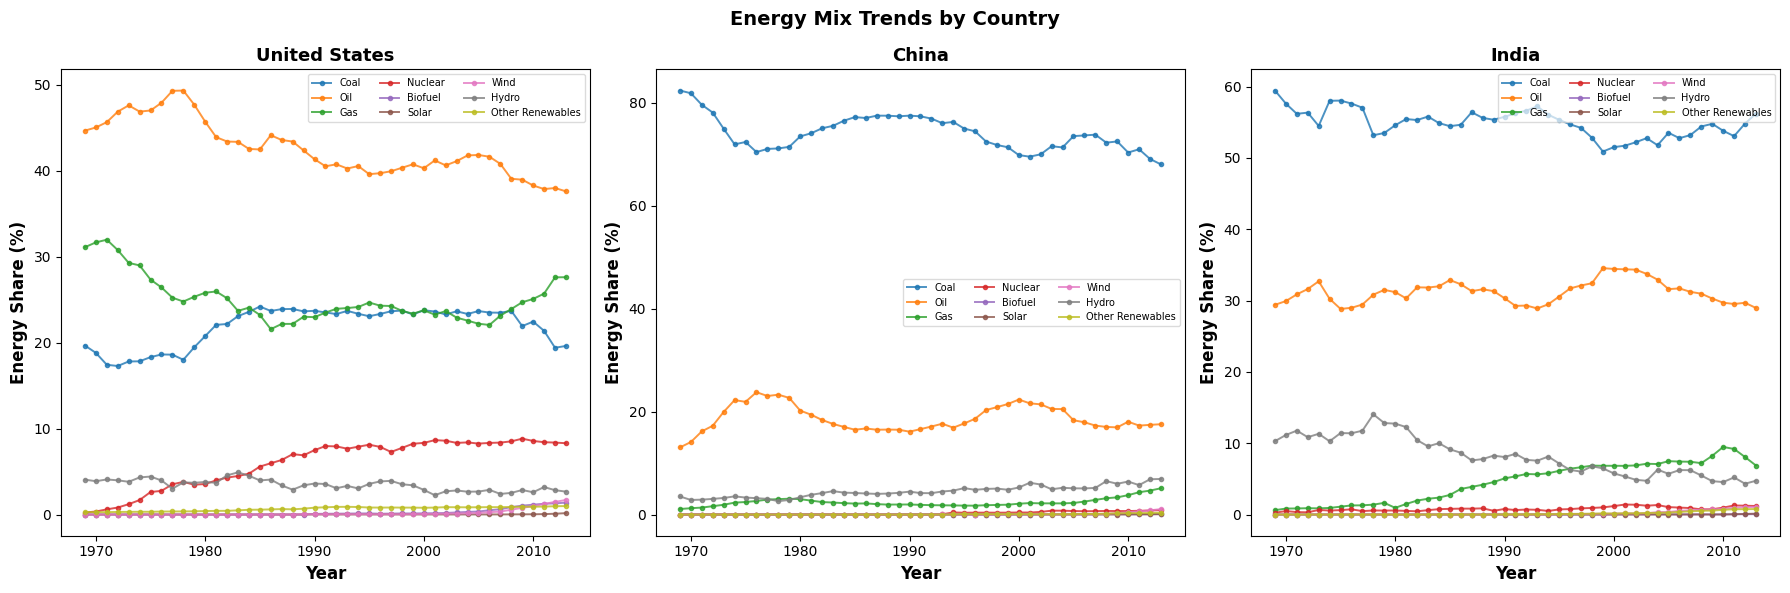

In [177]:
plot_energy_trends(train_3_df, SELECTED_COUNTRIES, DETAILED_PROPORTIONS)

### Hirfindahl-Hirschmann Index

* The total prorport should be excluded

HHI = sig (proportions)^2

- When HHI is close to 10,000: it means that variable is more concentrated

- When HHI is lower: the share amount of sources are more diversified

In [178]:
### Herfindahl-Hirschmann Index
def calculate_hhi(df, proportion_cols, hhi_category, max_lags=MAX_LAGS):
    df_copy = df.copy()

    current_cols = [col for col in proportion_cols if col in df_copy.columns]

    if current_cols:
        proportions = df_copy[current_cols].copy()
        df_copy[f'hhi_{hhi_category}'] = (proportions ** 2).sum(axis=1)

    for lag in range(1, max_lags + 1):
        lag_cols = [f"{col}_lag{lag}" for col in proportion_cols]
        lag_cols = [col for col in lag_cols if col in df_copy.columns]

        if lag_cols:
            proportions = df_copy[lag_cols].copy()
            df_copy[f'hhi_{hhi_category}_lag{lag}'] = (proportions ** 2).sum(axis=1)

    return df_copy

In [179]:
train_hhi_total = calculate_hhi(train_3_df, TOTAL_PROPORTIONS, 'total', MAX_LAGS)
hhi_cols = [col for col in train_hhi_total.columns if col.startswith('hhi_')]
print(hhi_cols)

['hhi_total', 'hhi_total_lag1', 'hhi_total_lag2', 'hhi_total_lag3', 'hhi_total_lag4']


In [180]:
train_hhi_total[hhi_cols].head(2)

,hhi_total,hhi_total_lag1,hhi_total_lag2,hhi_total_lag3,hhi_total_lag4
0,9322.826162,9195.280000,9306.84805,9277.940002,9230.896072
1,9449.640448,9322.826162,9195.28000,9306.848050,9277.940002


With using total for 2 categories would show how much concentrated the fossil fuel energy for the country,

since the primary energy source for all countries are fossil fuels

If there is a decrease in this measure, this indicates the country's pace of carbon source energy decoupling

This HHI total is however redundant due to the detailed proportions

In [181]:
train_hhi_detail = calculate_hhi(train_3_df, DETAILED_PROPORTIONS, 'detailed', MAX_LAGS)
hhi_cols = [col for col in train_hhi_detail.columns if col.startswith('hhi_')]
print(hhi_cols)

['hhi_detailed', 'hhi_detailed_lag1', 'hhi_detailed_lag2', 'hhi_detailed_lag3', 'hhi_detailed_lag4']


In [182]:
train_hhi_detail[hhi_cols].head(2)

,hhi_detailed,hhi_detailed_lag1,hhi_detailed_lag2,hhi_detailed_lag3,hhi_detailed_lag4
0,6969.779572,7052.748346,7272.253278,7421.021982,7629.920550
1,6908.154003,6969.779572,7052.748346,7272.253278,7421.021982


By showing detailed, if there is any trend of deacrease in hhi_detailed, this means the country attempts to diversify the energy resources

it suggests adding hhi of fossil resources composition would be valuable since this helps to distinguish coal-heavy nations from other gas-heavy nation

In [183]:
# Fossil composition calculation
def calculate_hhi_fossil_comp(df, max_lags=MAX_LAGS):
    """
    This is to calculate HHI for fossil fuel since the values of shares are out of the total energy
    """
    df_copy = df.copy()

    if all(col in df_copy.columns for col in ['coal_share_energy', 'oil_share_energy', 'gas_share_energy']):
        fossil_total = df_copy['coal_share_energy'] + df_copy['oil_share_energy'] + df_copy['gas_share_energy']
        coal_prop = (df_copy['coal_share_energy'] / fossil_total * 100) ** 2
        oil_prop = (df_copy['oil_share_energy'] / fossil_total * 100) ** 2
        gas_prop = (df_copy['gas_share_energy'] / fossil_total * 100) ** 2
        df_copy['hhi_fossil_comp'] = coal_prop + oil_prop + gas_prop

    for lag in range(1, max_lags + 1):
        coal_lag = f'coal_share_energy_lag{lag}'
        oil_lag = f'oil_share_energy_lag{lag}'
        gas_lag = f'gas_share_energy_lag{lag}'

        if all(col in df_copy.columns for col in [coal_lag, oil_lag, gas_lag]):
            fossil_total_lag = df_copy[coal_lag] + df_copy[oil_lag] + df_copy[gas_lag]
            coal_prop = (df_copy[coal_lag] / fossil_total_lag * 100) ** 2
            oil_prop = (df_copy[oil_lag] / fossil_total_lag * 100) ** 2
            gas_prop = (df_copy[gas_lag] / fossil_total_lag * 100) ** 2
            df_copy[f'hhi_fossil_comp_lag{lag}'] = coal_prop + oil_prop + gas_prop
    
    return df_copy

In [184]:
train_3_hhi_detail_fossil = calculate_hhi(train_3_df, DETAILED_PROPORTIONS, 'detailed', MAX_LAGS)
train_3_hhi_detail_fossil = calculate_hhi_fossil_comp(train_3_hhi_detail_fossil, MAX_LAGS)

In [185]:
hhi_cols = [col for col in train_3_hhi_detail_fossil.columns if col.startswith('hhi_')]
print(hhi_cols)

['hhi_detailed', 'hhi_detailed_lag1', 'hhi_detailed_lag2', 'hhi_detailed_lag3', 'hhi_detailed_lag4', 'hhi_fossil_comp', 'hhi_fossil_comp_lag1', 'hhi_fossil_comp_lag2', 'hhi_fossil_comp_lag3', 'hhi_fossil_comp_lag4']


In [186]:
train_3_hhi_detail_fossil[['country', 'year', 'hhi_detailed', 'hhi_fossil_comp']].head()

,country,year,hhi_detailed,hhi_fossil_comp
0,China,1969,6969.779572,7472.699335
1,China,1970,6908.154003,7308.359839
2,China,1971,6608.176575,6998.347975
3,China,1972,6408.051442,6806.077644
4,China,1973,6029.446455,6425.756057


In [187]:
save_d = 'data'
train_3_hhi_detail_fossil.to_csv(os.path.join(save_d, 'train_3_hhi_detail_fossil.csv'), index=False)

## Analysis for all countries
### Correlation

In [188]:
# Corr 1: co2 vs detail (percent values) (lags)
detailed_cols_all_lags = []
for col in DETAILED_PROPORTIONS:
    detailed_cols_all_lags.append(col)
    for lag in range(1, MAX_LAGS + 1):
        lag_col = f"{col}_lag{lag}"
        if lag_col in train_3_hhi_detail_fossil.columns:
            detailed_cols_all_lags.append(lag_col)

detailed_corr = train_3_hhi_detail_fossil[['co2'] + detailed_cols_all_lags].corr()['co2'].drop('co2').sort_values(ascending=False)

# Corr 2: co2 vs HHI detail (lags)
hhi_detailed_cols = [col for col in hhi_cols if 'detailed' in col]
hhi_detailed_corr = train_3_hhi_detail_fossil[['co2'] + hhi_detailed_cols].corr()['co2'].drop('co2').sort_values(ascending=False)

# Corr 3: co2 vs HHI fossil (lags)
hhi_fossil_cols = [col for col in hhi_cols if 'fossil_comp' in col]
hhi_fossil_corr = train_3_hhi_detail_fossil[['co2'] + hhi_fossil_cols].corr()['co2'].drop('co2').sort_values(ascending=False)

save_dir='data/01_02_results'
md_filepath = os.path.join(save_dir, 'hhi_correlation_total.md')
with open(md_filepath, 'w') as f:
    f.write("# HHI Correlation with CO2 for all countries\n\n")
    f.write("\n\n")
    
    f.write("## Table 1: CO2 Correlation with Energy Proportions\n\n")
    f.write(detailed_corr.to_markdown())
    f.write("\n\n")
    
    f.write("## Table 2: CO2 Correlation with HHI Detailed (lags)\n\n")
    f.write(hhi_detailed_corr.to_markdown())
    f.write("\n\n")
    
    f.write("## Table 3: CO2 Correlation with HHI Fossil Composition (lags)\n\n")
    f.write(hhi_fossil_corr.to_markdown())
    f.write("\n\n")

### Heatmap

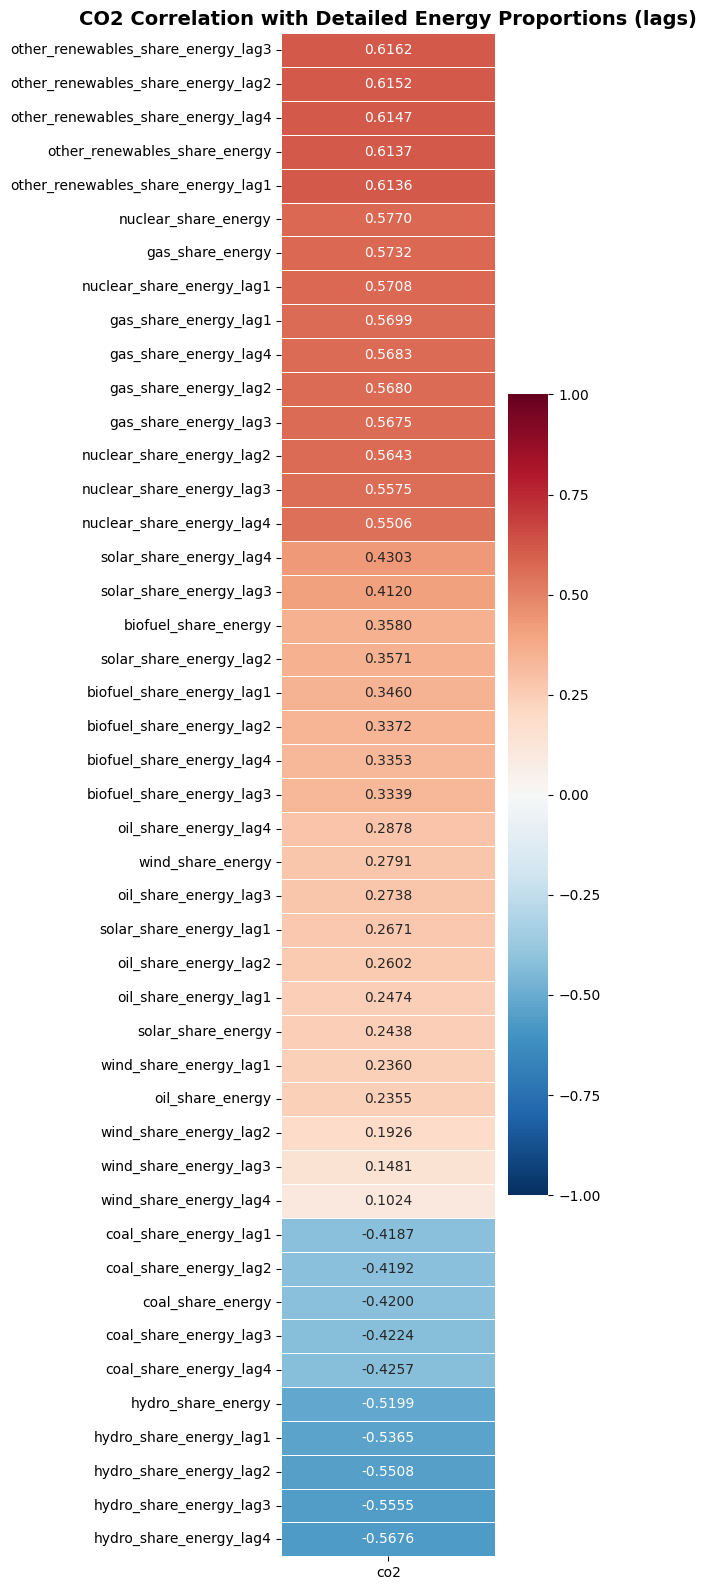

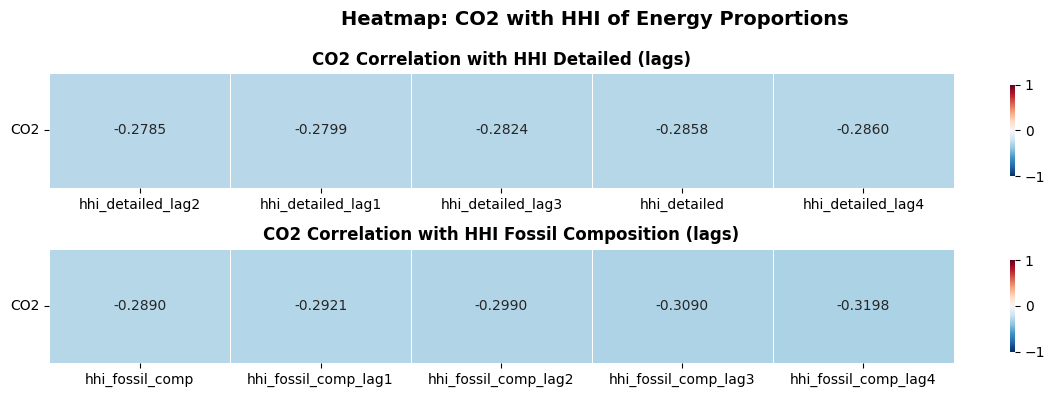

In [189]:
fig1, ax1 = plt.subplots(figsize=(6, 16))
detailed_corr_matrix = detailed_corr.to_frame()
sns.heatmap(detailed_corr_matrix, annot=True, fmt='.4f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax1)
ax1.set_title('CO2 Correlation with Detailed Energy Proportions (lags)', fontsize=14, fontweight='bold')
plt.tight_layout()

plot_filepath1 = os.path.join(save_dir, 'hhi_correlation_energy_prop_total.png')
plt.savefig(plot_filepath1, dpi=150, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(12, 4))

# HHI co2 vs detail
ax2 = axes[0]
hhi_detailed_corr_df = hhi_detailed_corr.to_frame().T
sns.heatmap(hhi_detailed_corr_df, annot=True, fmt='.4f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax2)
ax2.set_title('CO2 Correlation with HHI Detailed (lags)', fontsize=12, fontweight='bold')
ax2.set_yticklabels(['CO2'], rotation=0)

# HHI co2 vs fossil composition
ax3 = axes[1]
hhi_fossil_corr_df = hhi_fossil_corr.to_frame().T
sns.heatmap(hhi_fossil_corr_df, annot=True, fmt='.4f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax3)
ax3.set_title('CO2 Correlation with HHI Fossil Composition (lags)', fontsize=12, fontweight='bold')
ax3.set_yticklabels(['CO2'], rotation=0)

plt.suptitle('Heatmap: CO2 with HHI of Energy Proportions', fontsize=14, fontweight='bold')
plt.tight_layout()

plot_filepath = os.path.join(save_dir, 'hhi_heatmaps_total.png')
plt.savefig(plot_filepath, dpi=150, bbox_inches='tight')
plt.show()

## Analysis for each country

In [190]:
# Calculate correlations for each country
country_correlations = {}
for country in SELECTED_COUNTRIES:
    country_data = train_3_hhi_detail_fossil[train_3_hhi_detail_fossil['country'] == country]
    
    # Detailed proportions
    detailed_corr = country_data[['co2'] + detailed_cols_all_lags].corr()['co2'].drop('co2').sort_values(ascending=False)
    
    # HHI detailed
    hhi_detailed_corr = country_data[['co2'] + hhi_detailed_cols].corr()['co2'].drop('co2').sort_values(ascending=False)
    
    # HHI fossil comp
    hhi_fossil_corr = country_data[['co2'] + hhi_fossil_cols].corr()['co2'].drop('co2').sort_values(ascending=False)
    
    country_correlations[country] = {
        'detailed': detailed_corr,
        'hhi_detailed': hhi_detailed_corr,
        'hhi_fossil': hhi_fossil_corr
    }

In [191]:
# md file
md_filepath = os.path.join(save_dir, 'hhi_correlation_by_country.md')
with open(md_filepath, 'w') as f:
    f.write("# HHI Correlation with CO2 by Country\n\n")
    f.write("---\n\n")
    
    for country in SELECTED_COUNTRIES:
        f.write(f"## {country}\n\n")
        
        f.write(f"## Table 1: CO2 Correlation with Energy Proportions (lags)\n\n")
        f.write(country_correlations[country]['detailed'].to_markdown())
        f.write("\n\n")
        
        f.write(f"## Table 2: CO2 Correlation with HHI Detailed (lags)\n\n")
        f.write(country_correlations[country]['hhi_detailed'].to_markdown())
        f.write("\n\n")
        
        f.write(f"## Table 3: CO2 Correlation with HHI Fossil Composition (lags)\n\n")
        f.write(country_correlations[country]['hhi_fossil'].to_markdown())
        f.write("\n\n")

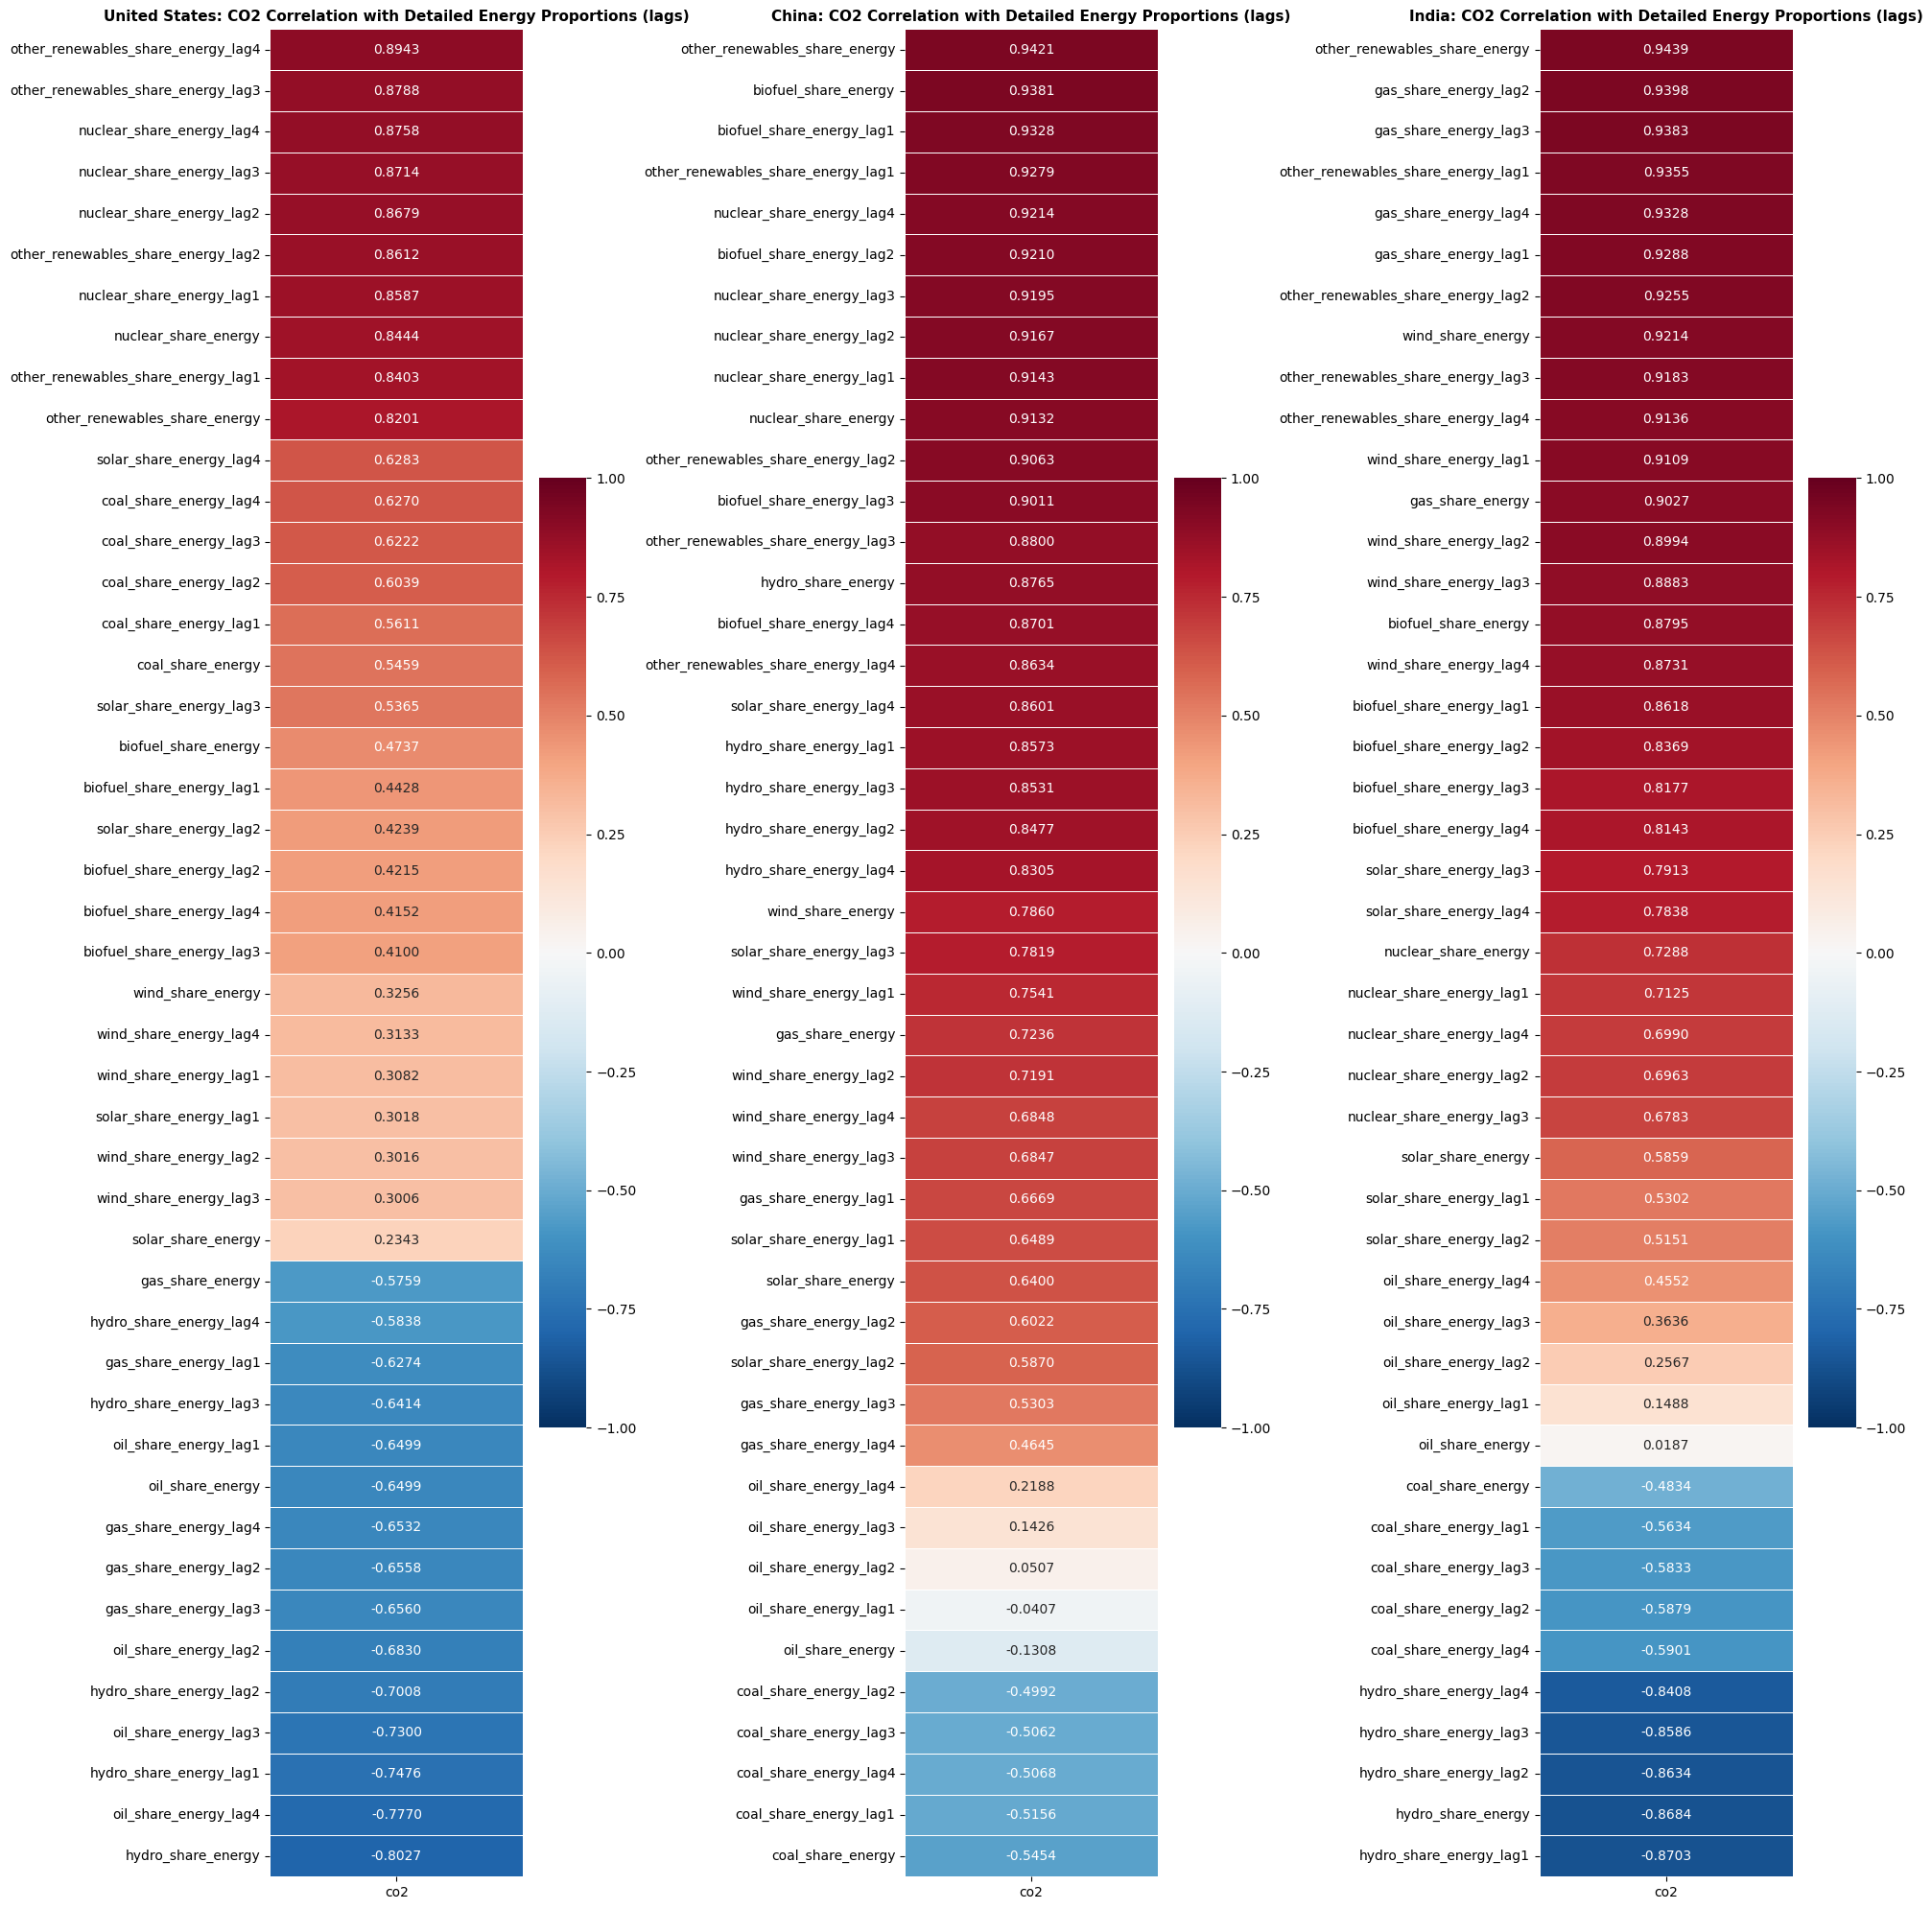

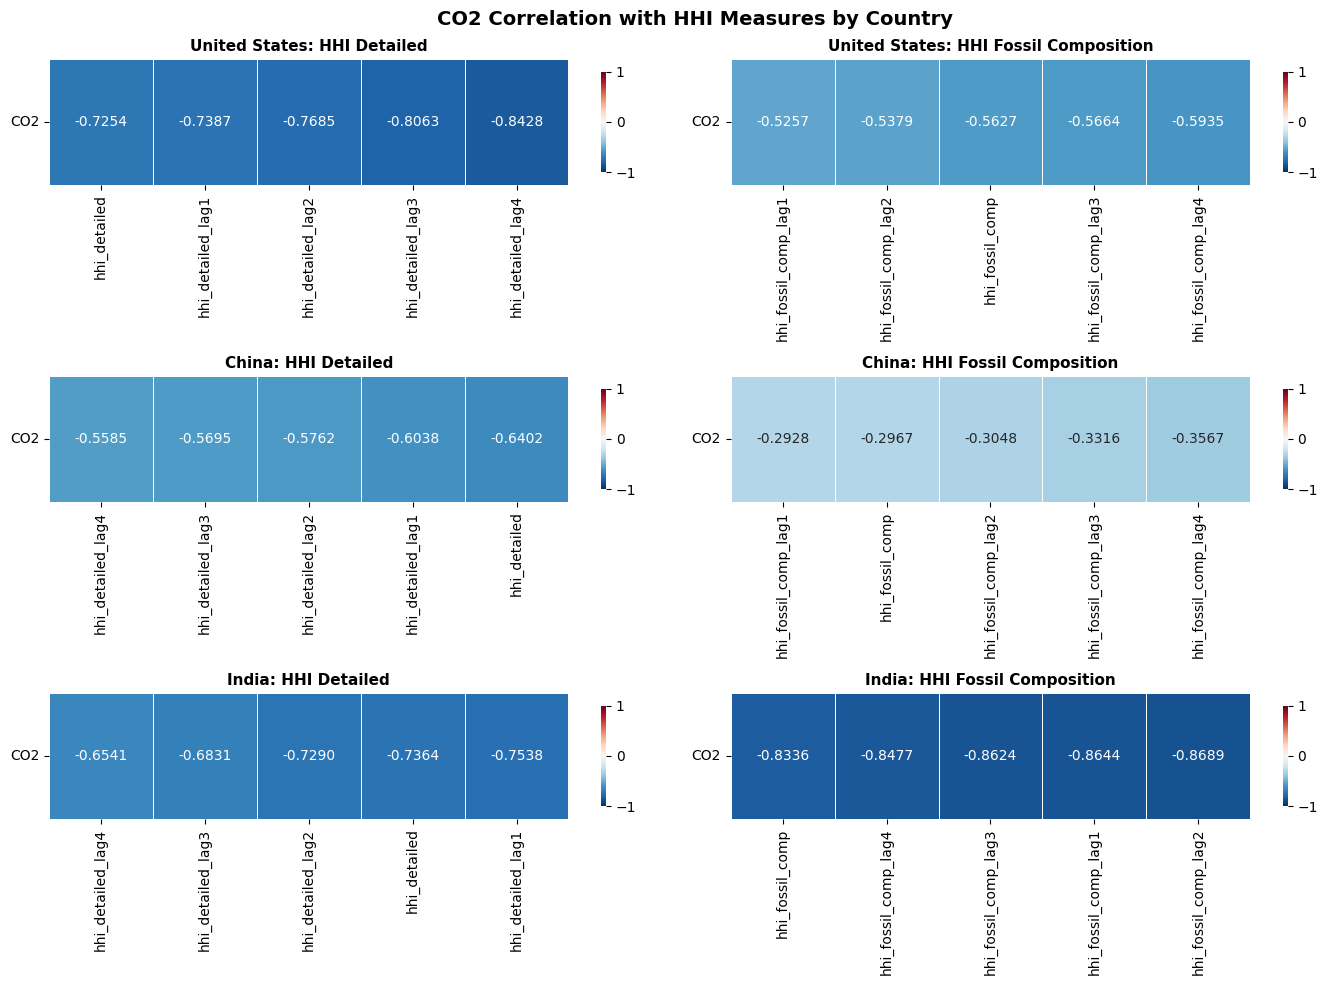

In [192]:
# Plot 1: Detailed Proportions
fig1, axes1 = plt.subplots(1, 3, figsize=(20, 20))

for idx, country in enumerate(SELECTED_COUNTRIES):
    ax = axes1[idx]
    detailed_corr_matrix = country_correlations[country]['detailed'].to_frame()
    sns.heatmap(detailed_corr_matrix, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title(f'{country}: CO2 Correlation with Detailed Energy Proportions (lags)', 
                 fontsize=11, fontweight='bold')

#plt.suptitle('CO2 Correlation with Detailed Energy Proportions by Country', fontsize=14, fontweight='bold')
plt.tight_layout()
plot_filepath1 = os.path.join(save_dir, 'hhi_correlation_energy_prop_by_country.png')
plt.savefig(plot_filepath1, dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: HHI measures - by country
fig2, axes2 = plt.subplots(3, 2, figsize=(14, 10))

for idx, country in enumerate(SELECTED_COUNTRIES):
    # HHI detailed
    ax_detailed = axes2[idx, 0]
    hhi_detailed_corr_df = country_correlations[country]['hhi_detailed'].to_frame().T
    sns.heatmap(hhi_detailed_corr_df, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax_detailed)
    ax_detailed.set_title(f'{country}: HHI Detailed', fontsize=11, fontweight='bold')
    ax_detailed.set_yticklabels(['CO2'], rotation=0)
    
    # HHI fossil internal
    ax_fossil = axes2[idx, 1]
    hhi_fossil_corr_df = country_correlations[country]['hhi_fossil'].to_frame().T
    sns.heatmap(hhi_fossil_corr_df, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax_fossil)
    ax_fossil.set_title(f'{country}: HHI Fossil Composition', fontsize=11, fontweight='bold')
    ax_fossil.set_yticklabels(['CO2'], rotation=0)

plt.suptitle('CO2 Correlation with HHI Measures by Country', fontsize=14, fontweight='bold')
plt.tight_layout()
plot_filepath2 = os.path.join(save_dir, 'hhi_heatmaps_by_country.png')
plt.savefig(plot_filepath2, dpi=150, bbox_inches='tight')
plt.show()